In [21]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn.functional as F
from torch_geometric_temporal.dataset import METRLADatasetLoader, ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.attention import ASTGCN, STConv
from torch_geometric_temporal.nn.recurrent import A3TGCN, DCRNN

pt_version = torch.__version__
print(pt_version)

1.13.1+cu117


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

In [24]:
RAW_URL = "https://raw.githubusercontent.com/Vishesh-Mittal/CongestionControl-GNN/ccgnn_dataset/"

step_size = 3 #timestep = step_size * 15
history_size = 4 #timesteps to be considered as history
num_of_vertices = 20

In [25]:
node_data = pd.read_csv(RAW_URL + "DIVE/DIVE_speed.csv", header = None)
edge_features = pd.read_csv(RAW_URL + "DIVE/DIVE_adj.csv", header = None)

URLError: <urlopen error [Errno 11001] getaddrinfo failed>

In [ ]:
stdScaler = StandardScaler()

node_data_array = np.array(node_data)
stdScaler.fit(node_data_array)
node_data_array = stdScaler.transform(node_data_array)
node_data_array

In [ ]:
node_data_array.shape

In [ ]:
#to be uploaded
edges = [
    (0, 0),(0, 1),(0, 4),(0, 10),(0, 15),(0, 17),
    (1, 0),(1, 1),(1, 2),(1, 4),
    (2, 1),(2, 2),(2, 3),(2, 12),
    (3, 2),(3, 3),(3, 7),(3, 9),(3, 12),
    (4, 0),(4, 1),(4, 4),(4, 6),(4, 18),
    (5, 5),(5, 10),(5, 11),(5, 12),
    (6, 6),(6, 7),(6, 18),
    (7, 3),(7, 6),(7, 7),
    (8, 8),(8, 9),(8, 19),
    (9, 3),(9, 8),(9, 9),
    (10, 0),(10, 5),(10, 10),(10, 11),
    (11, 11),(11, 5),(11, 10),(11, 13),
    (12, 3),(12, 5),(12, 12),
    (13, 11),(13, 13),
    (14, 14),(14, 17),
    (15, 0),(15, 15),
    (16, 16),(16, 17),(16, 18),(16, 19),
    (17, 0),(17, 14),(17, 16),
    (18, 4),(18, 6),(18, 16),(18, 18),
    (19, 8),(19, 16),(19, 19)
]
edges = np.array(edges)
edges.shape

In [26]:
#Required data

xs = []
edge_indices = []
ys = []
y_indices = []
edge_attr = []

#temporaries
edge_index = []
edge_feat = []

for edge in edges:
    edge_index.append(list(edge))
    edge_feat.append(edge_features[edge[0]][edge[1]])

final_edge_index = np.transpose(edge_index)

for index in range(len(node_data_array) - (history_size + step_size + 1)):

    node_features = node_data_array[index : index + history_size]
    subsequent_node_features = node_data_array[index + history_size + step_size]

    node_feat_transpose = np.transpose(node_features)
    node_feat_transpose_reshaped = node_feat_transpose.reshape(20,1,4)
    #node_feat_transpose_reshaped = node_feat_transpose #For DCRNN (Temp)
    subsequent_node_feat_transpose = np.transpose(subsequent_node_features)
    subsequent_node_feat_transpose_reshaped = subsequent_node_feat_transpose.reshape(20, 1)
    
    xs.append(node_feat_transpose_reshaped)
    ys.append(subsequent_node_feat_transpose_reshaped)
    edge_indices = final_edge_index #static
    edge_attr = edge_feat #static

xs = np.array(xs)
ys = np.array(ys)
edge_indices = np.array(edge_indices)
edge_attr = np.array(edge_attr)

In [27]:
print(f"""
      X feature shape: {xs.shape} \n
      Edge index shape: {edge_indices.shape} \n
      Edge attribute shape: {edge_attr.shape} \n 
      Labels shape: {ys.shape} \n
      """)


      X feature shape: (1337, 20, 1, 4) 

      Edge index shape: (2, 71) 

      Edge attribute shape: (71,) 
 
      Labels shape: (1337, 20, 1) 

      


In [28]:
i = 0
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {xs[i].shape} \n
      Edge index shape: {edge_indices[i].shape} \n
      Edge attribute shape: {edge_attr[i].shape} \n 
      Labels shape: {ys[i].shape} \n
      """)

Example of graph snapshot 0: 

      Node feature shape: (20, 1, 4) 

      Edge index shape: (71,) 

      Edge attribute shape: () 
 
      Labels shape: (20, 1) 

      


In [29]:
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in = 6, num_timesteps_out = 3)
sample = next(iter(dataset))
sample

#207 nodes x 2 features x 12 timesteps
#207 nodes x 12 future speed values

Data(x=[207, 2, 6], edge_index=[2, 1722], edge_attr=[1722], y=[207, 3])

In [30]:
dive_dataset = StaticGraphTemporalSignal(edge_indices, edge_attr, xs, ys)
m = next(iter(dive_dataset))
m

Data(x=[20, 1, 4], edge_index=[2, 71], edge_attr=[71], y=[20, 1])

In [31]:
i = 0
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {dataset[i].x.shape} \n
      Edge index shape: {dataset[i].edge_index.shape} \n
      Edge attribute shape: {dataset[i].edge_attr.shape} \n 
      Labels shape: {dataset[i].y.shape} \n
      """)

Example of graph snapshot 0: 

      Node feature shape: torch.Size([207, 2, 6]) 

      Edge index shape: torch.Size([2, 1722]) 

      Edge attribute shape: torch.Size([1722]) 
 
      Labels shape: torch.Size([207, 3]) 

      


In [32]:
i = 0
print(f"""Example of graph snapshot {i}: \n
      Node feature shape: {dive_dataset[i].x.shape} \n
      Edge index shape: {dive_dataset[i].edge_index.shape} \n
      Edge attribute shape: {dive_dataset[i].edge_attr.shape} \n 
      Labels shape: {dive_dataset[i].y.shape} \n
      """)

Example of graph snapshot 0: 

      Node feature shape: torch.Size([20, 1, 4]) 

      Edge index shape: torch.Size([2, 71]) 

      Edge attribute shape: torch.Size([71]) 
 
      Labels shape: torch.Size([20, 1]) 

      


<AxesSubplot:>

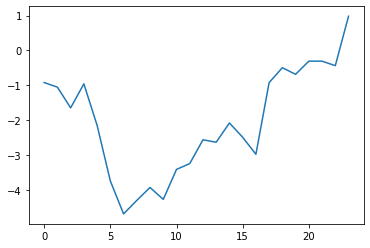

In [33]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
# sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dive_dataset)[:hours]]
sns.lineplot(data=sensor_labels)

In [34]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dive_dataset, train_ratio=0.8)
#train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)
print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))

Number of train buckets:  1069
Number of test buckets:  268


In [35]:
def trainModel(gnnModel, optimizer, train_dataset, subset = 2000, use_subset = False, use_weights = False, epochs=100):
    torch.cuda.empty_cache()
    
    # GPU support
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # cuda

    ds_fraction = len(list(train_dataset)) // 25
    gnnModel.train()

    print("Using {} for training...\n".format(device))
    for epoch in range(epochs): 
        mse = 0
        mae = 0
        rmse = 0
        mape = 0
        
        step = 0
        print(">> Epoch: {}\t| ".format(epoch + 1), end="")
        for snapshot in train_dataset:
            if(step % ds_fraction == 0):
                print("=", end="")
            snapshot = snapshot.to(device)
            # Get model predictions [20, 1, 3], [2, 71] -> [20]
            if (use_weights):
                y_hat = gnnModel(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            else:
                y_hat = gnnModel(snapshot.x, snapshot.edge_index)
            
            diff = y_hat-snapshot.y
            mse += torch.mean((diff)**2)
            rmse += torch.mean((diff)**2)
            mae += torch.mean(diff)
            mape += torch.mean(diff)
            
            step += 1
            if step > subset and use_subset:
              break
            
        print(" |", end="\t")
        mse = mse / (step + 1)
        rmse = (rmse / (step + 1)) ** (0.5)
        mae = mae / (step + 1)
        mape = 100 * mape / (step + 1)
        
        rmse.backward()
        optimizer.step()
        optimizer.zero_grad()
        print("MSE: {:.6f}, RMSE: {:.6f}, MAE: {:.6f}, MAPE: {:.6f}".format(mse.item(), rmse.item(), mae.item(), mape.item()))

def calTestMetrics(evalModel, test_dataset, use_weights = False):
    evalModel.eval()
    mse = 0
    mae = 0
    rmse = 0
    mape = 0
    step = 0
    horizon = 420

    # Store for analysis
    predictions = []
    labels = []

    for snapshot in test_dataset:
        snapshot = snapshot.to(device)
        # Get predictions
        if (use_weights):
            y_hat = evalModel(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        else:
            y_hat = evalModel(snapshot.x, snapshot.edge_index)
        
        scaled_y_hat = stdScaler.inverse_transform(np.transpose(y_hat.cpu().data.numpy()))
        scaled_y_act = stdScaler.inverse_transform(np.transpose(snapshot.y.cpu().data.numpy()))
        
        diff = np.transpose(scaled_y_hat)-np.transpose(scaled_y_act)
        diff = torch.from_numpy(diff)
        mse += torch.mean((diff)**2)
        rmse += torch.mean((diff)**2)
        mae += torch.mean(diff)
        mape += torch.mean(diff)
        
        labels.append(snapshot.y)
        predictions.append(y_hat)
        step += 1
        
        if step > horizon:
              break
        
    mse = mse / (step + 1)
    rmse = (rmse / (step + 1)) ** (0.5)
    mae = mae / (step + 1)
    mape = 100 * mape / (step + 1)
    print("MSE: {:.6f}, RMSE: {:.6f}, MAE: {:.6f}, MAPE: {:.6f}".format(mse.item(), rmse.item(), mae.item(), mape.item()))
    
    return predictions, labels

def chunks(lst, n):
    #Yield successive n-sized chunks from lst
    for i in range(0, len(lst), n):
        temp = np.array(lst[i:i + n])
        if(len(temp) == n):
            yield temp

# A3TGCN
Attention Temporal Graph Convolutional Network

In [36]:
class A3TGCNModel(torch.nn.Module):
    def __init__(self, node_features, periods, dropout=0.1, use_weights=False):
        super(A3TGCNModel, self).__init__()
        self.use_weights=use_weights
        
        self.dropout = dropout
        
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=16, 
                           periods=periods)
        self.linear = torch.nn.Linear(16, periods)

    def forward(self, x, edge_index, edge_weight=[]):
        if(self.use_weights):
            h = self.tgnn(x, edge_index, edge_weight)
        else:
            h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

A3TGCNModel(node_features=1, periods=1)

A3TGCNModel(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 16)
      (linear_z): Linear(in_features=32, out_features=16, bias=True)
      (conv_r): GCNConv(1, 16)
      (linear_r): Linear(in_features=32, out_features=16, bias=True)
      (conv_h): GCNConv(1, 16)
      (linear_h): Linear(in_features=32, out_features=16, bias=True)
    )
  )
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [93]:
# Create model and optimizers
a3tgcn_model = A3TGCNModel(node_features=1, periods=1).to(device)
optimizer = torch.optim.Adam(a3tgcn_model.parameters(), lr=0.01)

trainModel(a3tgcn_model, optimizer, train_dataset, epochs=100, use_weights=False)

Using cuda:0 for training...

>> Epoch: 1	| ========================== |	MSE: 0.955910, RMSE: 0.977707, MAE: 0.002377, MAPE: 0.237694
>> Epoch: 2	| ========================== |	MSE: 0.939784, RMSE: 0.969424, MAE: -0.014708, MAPE: -1.470827
>> Epoch: 3	| ========================== |	MSE: 0.923883, RMSE: 0.961188, MAE: -0.012859, MAPE: -1.285860
>> Epoch: 4	| ========================== |	MSE: 0.909053, RMSE: 0.953443, MAE: -0.006018, MAPE: -0.601823
>> Epoch: 5	| ========================== |	MSE: 0.895316, RMSE: 0.946211, MAE: 0.000781, MAPE: 0.078073
>> Epoch: 6	| ========================== |	MSE: 0.883410, RMSE: 0.939899, MAE: 0.004607, MAPE: 0.460716
>> Epoch: 7	| ========================== |	MSE: 0.873426, RMSE: 0.934573, MAE: 0.005050, MAPE: 0.504976
>> Epoch: 8	| ========================== |	MSE: 0.865819, RMSE: 0.930494, MAE: 0.002507, MAPE: 0.250719
>> Epoch: 9	| ========================== |	MSE: 0.860725, RMSE: 0.927753, MAE: -0.001436, MAPE: -0.143620
>> Epoch: 10	| ===========

>> Epoch: 78	| ========================== |	MSE: 0.831777, RMSE: 0.912018, MAE: 0.000449, MAPE: 0.044923
>> Epoch: 79	| ========================== |	MSE: 0.831762, RMSE: 0.912010, MAE: 0.000015, MAPE: 0.001504
>> Epoch: 80	| ========================== |	MSE: 0.831742, RMSE: 0.911999, MAE: -0.000188, MAPE: -0.018836
>> Epoch: 81	| ========================== |	MSE: 0.831725, RMSE: 0.911989, MAE: -0.000028, MAPE: -0.002767
>> Epoch: 82	| ========================== |	MSE: 0.831711, RMSE: 0.911982, MAE: 0.000329, MAPE: 0.032901
>> Epoch: 83	| ========================== |	MSE: 0.831696, RMSE: 0.911974, MAE: 0.000534, MAPE: 0.053391
>> Epoch: 84	| ========================== |	MSE: 0.831685, RMSE: 0.911968, MAE: 0.000309, MAPE: 0.030948
>> Epoch: 85	| ========================== |	MSE: 0.831673, RMSE: 0.911961, MAE: -0.000204, MAPE: -0.020363
>> Epoch: 86	| ========================== |	MSE: 0.831667, RMSE: 0.911958, MAE: -0.000725, MAPE: -0.072512
>> Epoch: 87	| ========================== |	MSE

In [94]:
a3tgcn_predictions, a3tgcn_labels = calTestMetrics(a3tgcn_model, test_dataset)

MSE: 3.468575, RMSE: 1.862411, MAE: 0.017605, MAPE: 1.760476


In [95]:
torch.save(a3tgcn_model, "a3tgcn"+str(step_size * 15)+"mins")

In [37]:
a3tgcn_model = torch.load("a3tgcn"+str(step_size * 15)+"mins")
print("Loaded A3TGCN for {} min time lag".format(step_size  * 15))

Loaded A3TGCN for 45 min time lag


In [38]:
a3tgcn_predictions, a3tgcn_labels = calTestMetrics(a3tgcn_model, test_dataset)

MSE: 3.468575, RMSE: 1.862411, MAE: 0.017605, MAPE: 1.760476


Data points:, (268,)


<AxesSubplot:>

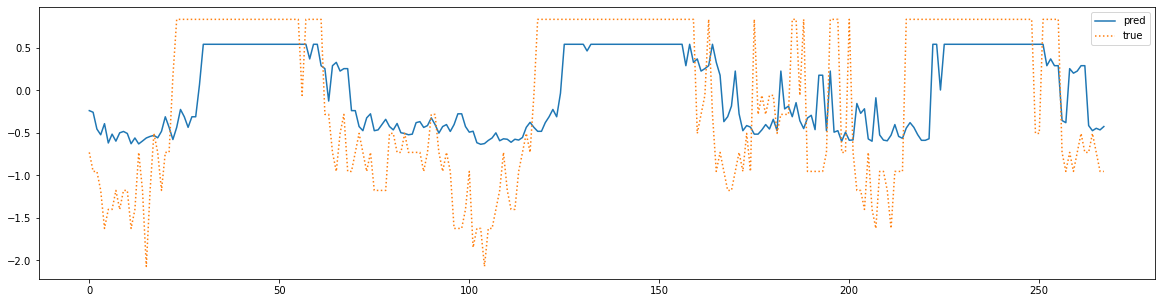

In [39]:
sensor = 15
timestep = 0 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in a3tgcn_predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in a3tgcn_labels])
#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
#labs  = np.asarray([label[sensor].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true", linestyle="dotted")

# DCRNN
Diffusion Convolutional Recurrent Neural Network

In [40]:
class DCRNNModel(torch.nn.Module):
    def __init__(self, node_features, periods, lags, num_nodes, use_weights=False):
        super(DCRNNModel, self).__init__()
        self.lags = lags
        self.num_nodes= num_nodes
        self.use_weights=use_weights
        
        #self.linear1 = torch.nn.Linear(node_features, lags)
        self.tgnn = DCRNN(in_channels=lags, out_channels=16, K=2)
        # Equals single-shot prediction
        self.linear2 = torch.nn.Linear(16, periods)

    def forward(self, x, edge_index, edge_weights=[]):
        
        x = torch.reshape(x, [self.num_nodes, self.lags])
        #x = self.linear1(x)
        if (self.use_weights):
            x = self.tgnn(x, edge_index, edge_weight)
        else:
            x = self.tgnn(x, edge_index)
        x = F.relu(x)
        x = self.linear2(x)
        return x

DCRNNModel(node_features=1, periods=1, lags=4, num_nodes=20)

DCRNNModel(
  (tgnn): DCRNN(
    (conv_x_z): DConv(20, 16)
    (conv_x_r): DConv(20, 16)
    (conv_x_h): DConv(20, 16)
  )
  (linear2): Linear(in_features=16, out_features=1, bias=True)
)

In [100]:
# Create model and optimizers
dcrnn_model = DCRNNModel(node_features=1, periods=1, lags=4, num_nodes=20).to(device)
optimizer = torch.optim.Adam(dcrnn_model.parameters(), lr=0.01)

trainModel(dcrnn_model, optimizer, train_dataset, epochs=100, use_weights=False)

Using cuda:0 for training...

>> Epoch: 1	| ========================== |	MSE: 1.021821, RMSE: 1.010852, MAE: -0.246146, MAPE: -24.614603
>> Epoch: 2	| ========================== |	MSE: 0.968909, RMSE: 0.984332, MAE: -0.233787, MAPE: -23.378702
>> Epoch: 3	| ========================== |	MSE: 0.924762, RMSE: 0.961646, MAE: -0.227652, MAPE: -22.765154
>> Epoch: 4	| ========================== |	MSE: 0.885146, RMSE: 0.940822, MAE: -0.219769, MAPE: -21.976931
>> Epoch: 5	| ========================== |	MSE: 0.850525, RMSE: 0.922239, MAE: -0.207161, MAPE: -20.716125
>> Epoch: 6	| ========================== |	MSE: 0.821809, RMSE: 0.906537, MAE: -0.189182, MAPE: -18.918209
>> Epoch: 7	| ========================== |	MSE: 0.798220, RMSE: 0.893432, MAE: -0.164153, MAPE: -16.415335
>> Epoch: 8	| ========================== |	MSE: 0.778986, RMSE: 0.882602, MAE: -0.131141, MAPE: -13.114054
>> Epoch: 9	| ========================== |	MSE: 0.764074, RMSE: 0.874113, MAE: -0.091015, MAPE: -9.101546
>> Epoch

>> Epoch: 78	| ========================== |	MSE: 0.730092, RMSE: 0.854454, MAE: 0.002220, MAPE: 0.222003
>> Epoch: 79	| ========================== |	MSE: 0.730006, RMSE: 0.854404, MAE: 0.002521, MAPE: 0.252071
>> Epoch: 80	| ========================== |	MSE: 0.729893, RMSE: 0.854338, MAE: 0.001910, MAPE: 0.191025
>> Epoch: 81	| ========================== |	MSE: 0.729773, RMSE: 0.854268, MAE: 0.000619, MAPE: 0.061890
>> Epoch: 82	| ========================== |	MSE: 0.729665, RMSE: 0.854205, MAE: -0.000988, MAPE: -0.098770
>> Epoch: 83	| ========================== |	MSE: 0.729567, RMSE: 0.854147, MAE: -0.002402, MAPE: -0.240237
>> Epoch: 84	| ========================== |	MSE: 0.729461, RMSE: 0.854085, MAE: -0.003237, MAPE: -0.323717
>> Epoch: 85	| ========================== |	MSE: 0.729347, RMSE: 0.854018, MAE: -0.003339, MAPE: -0.333913
>> Epoch: 86	| ========================== |	MSE: 0.729229, RMSE: 0.853949, MAE: -0.002768, MAPE: -0.276848
>> Epoch: 87	| ========================== |	M

In [101]:
dcrnn_predictions, dcrnn_labels = calTestMetrics(dcrnn_model, test_dataset)

MSE: 3.171868, RMSE: 1.780974, MAE: -0.002365, MAPE: -0.236479


In [102]:
torch.save(dcrnn_model, "dcrnn"+str(step_size * 15)+"mins")

In [41]:
dcrnn_model = torch.load("dcrnn"+str(step_size * 15)+"mins")
print("Loaded DCRNN for {} min time lag".format(step_size  * 15))

Loaded DCRNN for 45 min time lag


In [42]:
dcrnn_predictions, dcrnn_labels = calTestMetrics(dcrnn_model, test_dataset)

MSE: 3.171868, RMSE: 1.780974, MAE: -0.002365, MAPE: -0.236479


Data points:, (268,)


<AxesSubplot:>

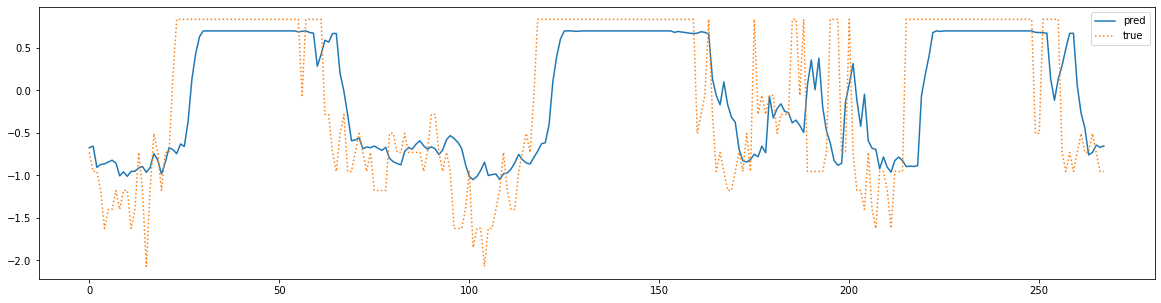

In [43]:
sensor = 15
timestep = 0 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in dcrnn_predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in dcrnn_labels])
#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
#labs  = np.asarray([label[sensor].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true", linestyle="dotted")

# ASTGCN
Attention Based Spatial-Temporal Graph Convolutional Network

In [117]:
xs.shape, ys.shape

((1339, 20, 1, 4), (1339, 20, 1))

In [142]:
xs_batch = np.array(list(chunks(xs, 1)))
ys_batch = np.array(list(chunks(ys, 1)))
xs_batch.shape, ys_batch.shape

((1339, 1, 20, 1, 4), (1339, 1, 20, 1))

In [143]:
batched_dive_dataset = StaticGraphTemporalSignal(edge_indices, edge_attr, xs_batch, ys_batch)
m = next(iter(batched_dive_dataset))
m

Data(x=[1, 20, 1, 4], edge_index=[2, 71], edge_attr=[71], y=[1, 20, 1])

In [144]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(batched_dive_dataset, train_ratio=0.8)
print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))

Number of train buckets:  1071
Number of test buckets:  268


In [148]:
class ASTGCNModel(torch.nn.Module):
    def __init__(self, node_features, periods, lags, num_nodes, use_weights=False, dropout=0.1):
        super(ASTGCNModel, self).__init__()
        self.lags = lags
        self.num_nodes= num_nodes
        self.use_weights=use_weights
        self.dropout = dropout
        
        self.tgnn = ASTGCN(
            nb_block=2, 
            in_channels=node_features, 
            K=2, 
            nb_chev_filter=4, 
            nb_time_filter=4, 
            time_strides=lags, 
            num_for_predict=1, 
            len_input=lags, 
            num_of_vertices=num_nodes)

    def forward(self, x, edge_index, edge_weights=[]):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        
        #x = torch.reshape(x, [self.num_nodes, self.lags])
        #x = self.linear1(x)
        if (self.use_weights):
            x = self.tgnn(x, edge_index, edge_weight)
        else:
            x = self.tgnn(x, edge_index)
        x = F.relu(x)
        return x

ASTGCNModel(node_features=1, periods=1, lags=4, num_nodes=20)

ASTGCNModel(
  (tgnn): ASTGCN(
    (_blocklist): ModuleList(
      (0): ASTGCNBlock(
        (_temporal_attention): TemporalAttention()
        (_spatial_attention): SpatialAttention()
        (_chebconv_attention): ChebConvAttention(1, 4, K=2, normalization=None)
        (_time_convolution): Conv2d(4, 4, kernel_size=(1, 3), stride=(1, 4), padding=(0, 1))
        (_residual_convolution): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 4))
        (_layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      )
      (1): ASTGCNBlock(
        (_temporal_attention): TemporalAttention()
        (_spatial_attention): SpatialAttention()
        (_chebconv_attention): ChebConvAttention(4, 4, K=2, normalization=None)
        (_time_convolution): Conv2d(4, 4, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (_residual_convolution): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
        (_layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
      )
    )
    (_final

In [149]:
# Create model and optimizers
astgcn_model = ASTGCNModel(node_features=1, periods=1, lags=4, num_nodes=20).to(device)
optimizer = torch.optim.Adam(astgcn_model.parameters(), lr=0.01)

trainModel(astgcn_model, optimizer, train_dataset, epochs=100, use_weights=False)

Using cuda:0 for training...

>> Epoch: 1	| ========================== |	MSE: 4.551182, RMSE: 2.133350, MAE: 1.906772, MAPE: 190.677170
>> Epoch: 2	| ========================== |	MSE: 3.840034, RMSE: 1.959600, MAE: 1.708484, MAPE: 170.848419
>> Epoch: 3	| ========================== |	MSE: 3.243470, RMSE: 1.800964, MAE: 1.521359, MAPE: 152.135910
>> Epoch: 4	| ========================== |	MSE: 2.742815, RMSE: 1.656145, MAE: 1.343759, MAPE: 134.375885
>> Epoch: 5	| ========================== |	MSE: 2.334486, RMSE: 1.527902, MAE: 1.179498, MAPE: 117.949760
>> Epoch: 6	| ========================== |	MSE: 2.005784, RMSE: 1.416257, MAE: 1.029236, MAPE: 102.923630
>> Epoch: 7	| ========================== |	MSE: 1.740285, RMSE: 1.319199, MAE: 0.890431, MAPE: 89.043045
>> Epoch: 8	| ========================== |	MSE: 1.523645, RMSE: 1.234360, MAE: 0.758923, MAPE: 75.892258
>> Epoch: 9	| ========================== |	MSE: 1.347224, RMSE: 1.160700, MAE: 0.632046, MAPE: 63.204632
>> Epoch: 10	| ====

KeyboardInterrupt: 

In [141]:
astgcn_predictions, astgcn_labels = calTestMetrics(astgcn_model, test_dataset)

ValueError: not enough values to unpack (expected 4, got 3)

Data points:, (67, 1)


<AxesSubplot:>

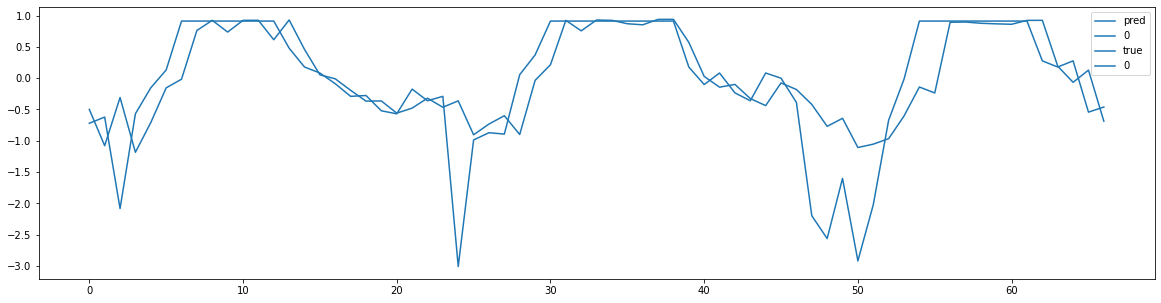

In [139]:
sensor = 15
timestep = 0 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in astgcn_predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in astgcn_labels])
#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
#labs  = np.asarray([label[sensor].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true", linestyle="dotted")

Data points:, (268,)


<AxesSubplot:>

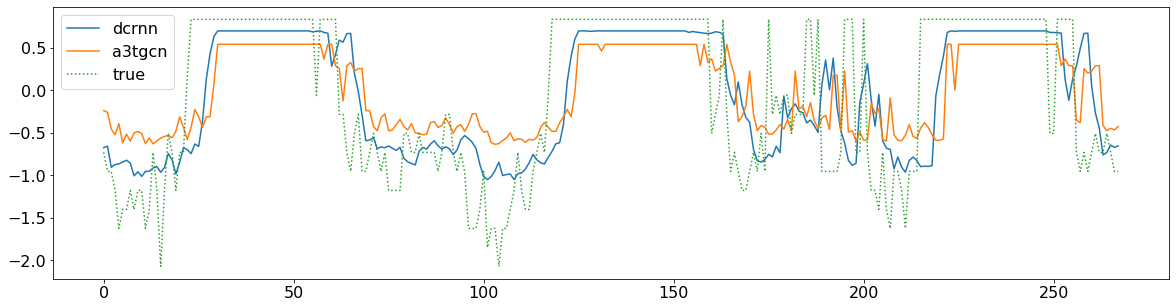

In [44]:
sensor = 15
timestep = 0 
a3tgcn_preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in a3tgcn_predictions])
dcrnn_preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in dcrnn_predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in a3tgcn_labels])
plt.rcParams.update({'font.size': 16})

print("Data points:,", preds.shape)

plt.figure(figsize=(20,5))
sns.lineplot(data=dcrnn_preds, label="dcrnn")
sns.lineplot(data=a3tgcn_preds, label="a3tgcn")
sns.lineplot(data=labs, label="true", linestyle="dotted")

In [49]:
stdScaler.inverse_transform([[0.6]])

ValueError: non-broadcastable output operand with shape (1,1) doesn't match the broadcast shape (1,20)